# Images Preprocessing
首先匯入 train、test的csv檔,根據 filename 內的檔案名稱逐一匯入圖檔後依據 x、y 的位置切出人臉,並分別儲存至train、test資料夾

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import os

In [56]:
def get_data(data,path,data_type = 'train'):
    class1 = data['label'].unique()
    faces = []
    for j in range(len(data)):
        filename = data.loc[j,'filename']
        label = data.loc[j,'label']
        im = Image.open(os.path.join(path,'images',filename))
        im = im.convert('RGB')
        im1 = np.asarray(im, dtype = np.uint8)
        loc = data.loc[j,'ymin'],data.loc[j,'ymax'],data.loc[j,'xmin'],data.loc[j,'xmax']
        ymin,ymax,xmin,xmax = loc
        im2 = im1[ymin:ymax,xmin:xmax,:]
        im4 = Image.fromarray(im2,'RGB')
        if not os.path.exists(os.path.join(path,data_type)):
            os.mkdir(os.path.join(path,data_type))
            for i in class1:
                os.mkdir(os.path.join(path,data_type,i))
        path1 = os.path.join(path,data_type,label,"%d.jpg"% j)
        im4.save(os.path.join(path1))

In [57]:
train = pd.read_csv(r'C:\Users\517super\Desktop\Deep_Learning\CNN\train.csv')
test = pd.read_csv(r'C:\Users\517super\Desktop\Deep_Learning\CNN\test.csv')
path = r'C:\Users\517super\Desktop\Deep_Learning\CNN'
get_data(train,path,data_type = 'train')
get_data(test,path,data_type = 'test')

# 模型訓練
將所有照片壓縮成一樣大小(32X32)後丟入CNN模型中<br>
學習率為0.001<br>
batch_size = 128<br>
num_epochs = 50<br>

In [101]:
import torchvision.datasets as dset
import torchvision.transforms as trns
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
transform = trns.Compose([
    trns.Resize((32, 32)),
    trns.ToTensor(),
    trns.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225]),
])
train_dataset = dset.ImageFolder('./train',transform = transform)
test_dataset = dset.ImageFolder('./test',transform = transform)

In [103]:
print(train_dataset.classes)
classes = train_dataset.classes
print(train_dataset.class_to_idx)
class_to_idx = train_dataset.class_to_idx

['bad', 'good', 'none']
{'bad': 0, 'good': 1, 'none': 2}


In [22]:
LR = 0.001
batch_size = 128
num_epochs = 20

In [91]:
train_dataset = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size, shuffle=False)

# 模型描述
## Convolution 1
input_shape=(3,32,32), kernel_size=(5, 5), output = (32,28,28)，其中28=32-5+1<br>
## Max pool 1
input_shape=(32,28,28), kernel_size=2, stride=2, padding=0, output = (32,14,14)
## Convolution 2
input_shape=(32,14,14), kernel_size=(5, 5), output = (64,10,10)
## Max pool 2
input_shape=(64,10,10), kernel_size=2, stride=2, padding=0, output = (64,5,5)
## Fully connected 1 
input_shape=(64*5*5), output = 1024
## Fully connected 2
input = 1024,output = 3(3個類別)

In [17]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn1 = nn.Conv2d(3, 32, kernel_size=5, stride=1) 
        self.relu1 = nn.ReLU() 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(32,64, kernel_size=5, stride=1) 
        self.relu2 = nn.ReLU() 
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(64 * 5 * 5, 1024)
        self.fc2 = nn.Linear(1024, 3)
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out) 
        out = self.fc2(out)
        return out

In [37]:
model = CNN_Model()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # label不用轉one_hot

CNN_Model(
  (cnn1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
)


In [38]:
def fit_model(model, loss_func, optimizer, num_epochs,train_loader, test_loader):
    # Traning the Model
    #history-like list for store loss & acc value
    training_loss = []
    training_accuracy = []
    testing_accuracy = []
    for epoch in range(num_epochs):
        #training model & store loss & acc / epoch
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            # 1.Define variables
            #train1 = Variable(images)
            #labels = Variable(labels)
            # 2.Clear gradients
            optimizer.zero_grad()
            # 3.Forward propagation
            outputs = model(images)
            # 4.Calculate softmax and cross entropy loss
            train_loss = loss_func(outputs, labels.long())
            # 5.Calculate gradients
            train_loss.backward()
            # 6.Update parameters
            optimizer.step()
            # 7.Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # 8.Total number of labels
            total_train += len(labels)
            # 9.Total correct predictions
            correct_train += (predicted == labels).sum().item()
        #10.store val_acc / epoch
        train_accuracy = 100 * correct_train / total_train
        training_accuracy.append(train_accuracy)
        # 11.store loss / epoch
        training_loss.append(train_loss.item())
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            test_accuracy = correct / total * 100
        testing_accuracy.append(test_accuracy)
        print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Test_acc: {:.6f}%'.format(epoch+1, num_epochs, train_loss.data, train_accuracy, test_accuracy))
    torch.save(model.state_dict(), 'params.pkl')
    return training_loss, training_accuracy, testing_accuracy

In [39]:
training_loss, training_accuracy, testing_accuracy = fit_model(model, loss_func, optimizer, num_epochs, train_dataset, test_dataset)

Train Epoch: 1/20 Traing_Loss: 0.26751264929771423 Traing_acc: 86.621315% Test_acc: 90.609137%
Train Epoch: 2/20 Traing_Loss: 0.213409423828125 Traing_acc: 93.877551% Test_acc: 89.086294%
Train Epoch: 3/20 Traing_Loss: 0.04805143177509308 Traing_acc: 94.075964% Test_acc: 92.893401%
Train Epoch: 4/20 Traing_Loss: 0.22371135652065277 Traing_acc: 95.436508% Test_acc: 92.131980%
Train Epoch: 5/20 Traing_Loss: 0.15768305957317352 Traing_acc: 95.861678% Test_acc: 91.624365%
Train Epoch: 6/20 Traing_Loss: 0.01245174091309309 Traing_acc: 96.740363% Test_acc: 93.401015%
Train Epoch: 7/20 Traing_Loss: 0.05127827078104019 Traing_acc: 97.080499% Test_acc: 93.654822%
Train Epoch: 8/20 Traing_Loss: 0.0525960773229599 Traing_acc: 97.278912% Test_acc: 94.162437%
Train Epoch: 9/20 Traing_Loss: 0.18877214193344116 Traing_acc: 97.448980% Test_acc: 93.147208%
Train Epoch: 10/20 Traing_Loss: 0.06346598267555237 Traing_acc: 97.675737% Test_acc: 93.654822%
Train Epoch: 11/20 Traing_Loss: 0.005823066923767328

In [25]:
import matplotlib.pyplot as plt

In [44]:
j = ['Average Cross Entropy Loss','Training Accuracy','Testing Accuracy']
j1 = [training_loss, training_accuracy, testing_accuracy]

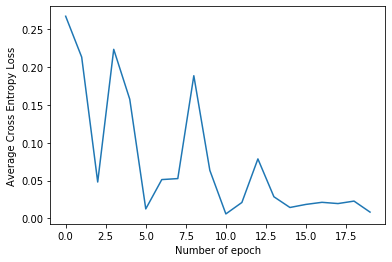

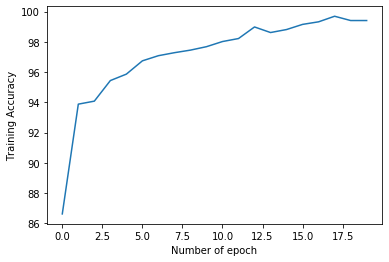

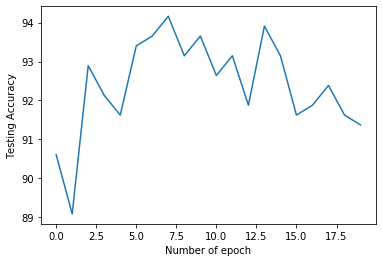

In [87]:
def result_plot(num_epoch,result,Type):
    for i in range(len(result)):
        plt.plot(list(range(num_epoch)),result[i])
        plt.xlabel('Number of epoch')
        plt.ylabel(Type[i])
        plt.show()
result_plot(20,j1,j)

In [95]:
model = CNN_Model()
model.load_state_dict(torch.load('params.pkl'))
model.eval()
def confusmatrix(data,classes):
    matrix = np.zeros([len(classes),len(classes)],dtype=int)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(predicted)):
                matrix[labels[i]][predicted[i]]+=1
    matrix = pd.DataFrame(matrix,columns = classes, index = classes)
    return matrix

下方的表為 Good、Bad、None 在 train 與 test 之預測值的混淆矩陣,其中可以發現在 None 這個類別中的準確率相當的低,可能是因為 None 這個類別在data set 中的資料筆數相當少(分別在 train 與 test 中只有 104 和 22),在訓練時,這些少數型的資料可能會變成干擾不但可能使整體預測資料的準確率變低。

In [99]:
print('Test')
print(confusmatrix(test_dataset,classes))

Test
      bad  good  none
bad    78     8     3
good    4   272     7
none    6     6    10


In [100]:
print("train")
print(confusmatrix(train_dataset,classes))

train
      bad  good  none
bad   576     2     0
good    1  2841     4
none    0     1   103


In [104]:
from PIL import ImageDraw,ImageFont

In [122]:
idx_to_class = {i:classes[i] for i in range(len(classes))}
path = r'C:\Users\517super\Desktop\Deep_Learning\CNN'
train = pd.read_csv(os.path.join(path,'train.csv'))
pic = '0_10725.jpg'
pic_train = train[train['filename']==pic].reset_index()
img =Image.open(os.path.join(path,'images',pic))

In [160]:
model = CNN_Model()
model.load_state_dict(torch.load('params.pkl'))
model.eval()
def predict_one_sample(pic):
    pic_train = train[train['filename']==pic].reset_index()
    img =Image.open(os.path.join(path,'images',pic))
    draw =ImageDraw.Draw(img)
    font  = ImageFont.truetype("arial.ttf", 15)
    im = img.convert('RGB')
    im1 = np.asarray(im, dtype = np.uint8)
    for j in range(pic_train.shape[0]):
        loc = pic_train.loc[j,'ymin'], pic_train.loc[j,'ymax'], pic_train.loc[j,'xmin'], pic_train.loc[j,'xmax']
        ymin,ymax,xmin,xmax = loc
        im2 = im1[ymin:ymax,xmin:xmax,:]
        im4 = Image.fromarray(im2,'RGB')
        image_tensor = transform(im4).unsqueeze_(0)
        out = model(image_tensor)
        _, predicted = torch.max(out.data, 1)
        predicted = idx_to_class[predicted.item()]
        if predicted=='good':
            color=(0,255,0)
        elif predicted=='bad':
            color=(255,0,0)
        else:
            color=(0,0,255)
        draw.rectangle((pic_train.loc[j,'xmin'],pic_train.loc[j,'ymax'],pic_train.loc[j,'xmin']+45,pic_train.loc[j,'ymax']+20),fill= color,width = 1)    
        draw.rectangle((pic_train.loc[j,'xmin'],pic_train.loc[j,'ymin'],pic_train.loc[j,'xmax'],pic_train.loc[j,'ymax']),outline= color,width = 4)
        draw.text((pic_train.loc[j,'xmin'],pic_train.loc[j,'ymax'])," " + predicted, fill = (0,0,0),font=font)
        print(predicted)
    return img

good
bad
bad
good


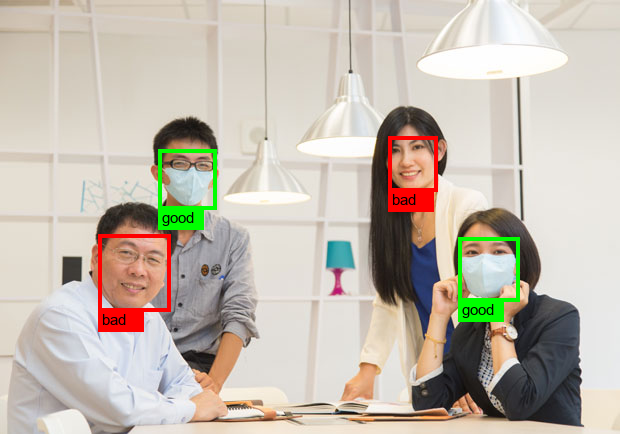

In [161]:
predict_one_sample(pic)